In [120]:
import pandas as pd
from pathlib import Path
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [121]:
processed_data_path = Path("../data/processed/CPFL-RS-Informações industrial grupo A.xlsx").resolve()

data = pd.read_csv(processed_data_path)
data

,Empresa,Nº instalação,Classe de cálculo,SubGrupo de Tensão,Município,Item Faturamento BW,SubAgrupador de Fatu,Meses,Valores
0,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,Cons Ponta Band Verde - TE,Consumo,1.2024,463.296
1,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,Consumo F Ponta Band Verde-TE,Consumo,1.2024,1365.264
2,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,Energ Atv Inj. mUC oPT- Pta-TE,Energia Compensada,1.2024,-420.816
3,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,Energia Atv Injetada Fponta TE,Energia Compensada,1.2024,-1365.264
4,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,Energia Atv Injetada Ponta TE,Energia Compensada,1.2024,-42.480
...,...,...,...,...,...,...,...,...,...
23528,Grupo RGE,Cliente 347,Industrial,A4,CRUZ ALTA,USD Consumo Reativo Ponta,FER,12.2024,11413.662
23529,Grupo RGE,Cliente 348,Industrial,A4,IPE,USD Consumo Reativo Fora Ponta,FER,12.2024,5.771
23530,Grupo RGE,Cliente 348,Industrial,A4,IPE,USD Consumo Reativo Ponta,FER,12.2024,0.267
23531,Grupo RGE,Cliente 349,Industrial,A4,PORTAO,USD Consumo Reativo Fora Ponta,FER,12.2024,77.091


In [122]:
# Ajustar formato da columa Meses
data["Meses"] = data["Meses"].apply(lambda x: int(str(x).split(".")[0]))

In [123]:
data["Item Faturamento BW"] = data["Item Faturamento BW"].apply(lambda x: x.replace(" ",""))
for i, item in enumerate(np.sort(data["Item Faturamento BW"].unique())):
    print(f"{i+1:02d} - {item}")


01 - ConsPontaBandVerde-TE
02 - ConsumoFPontaBandVerde-TE
03 - ConsumoReativoExcForaPonta
04 - ConsumoReativoExcPonta
05 - DemandaDifContrato[kW]-TUSD
06 - DemandaFPonta[kW]-TUSD
07 - DemandaPonta[kW]-TUSD
08 - Demanda[kW]-TUSD
09 - EnergAtvInj.mUCmPT-FPTE
10 - EnergAtvInj.mUCmPT-Pta-TE
11 - EnergAtvInj.mUCoPT-FP-TE
12 - EnergAtvInj.mUCoPT-FPTE
13 - EnergAtvInj.mUCoPT-Pta-TE
14 - EnergAtvInj.oUCmPT-FPTE
15 - EnergAtvInj.oUCmPT-Pta-TE
16 - EnergAtvInj.oUCoPT-Pta-TE
17 - EnergiaAtvInjetadaFpontaTE
18 - EnergiaAtvInjetadaPontaTE
19 - TusdEncConsFPonta[kWh]
20 - TusdEncConsPonta[kWh]
21 - USDConsumoReativoForaPonta
22 - USDConsumoReativoPonta
23 - UsoSist.Distr.
24 - UsoSistDistrFPonta
25 - UsoSistDistrGeração[kW]
26 - UsoSistDistrPonta


In [124]:
index = [
    'Empresa',
    'Nº instalação',
    'Classe de cálculo',
    'SubGrupo de Tensão',
    'Município',
    "Meses"
    ]

columns = "Item Faturamento BW"
value = "Valores"

data_piv = pd.pivot_table(data, values=value, index=index, columns=columns)

data_piv = data_piv.reset_index()
data_piv


Item Faturamento BW,Empresa,Nº instalação,Classe de cálculo,SubGrupo de Tensão,Município,Meses,ConsPontaBandVerde-TE,ConsumoFPontaBandVerde-TE,ConsumoReativoExcForaPonta,ConsumoReativoExcPonta,...,EnergiaAtvInjetadaFpontaTE,EnergiaAtvInjetadaPontaTE,TusdEncConsFPonta[kWh],TusdEncConsPonta[kWh],USDConsumoReativoForaPonta,USDConsumoReativoPonta,UsoSist.Distr.,UsoSistDistrFPonta,UsoSistDistrGeração[kW],UsoSistDistrPonta
0,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,1,463.296,1365.264,397.253,NaN,...,-1365.264,-42.480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,2,543.600,1403.424,469.658,26.657,...,-1403.424,-70.944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,3,564.432,1835.376,386.102,NaN,...,-1835.376,-20.928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,4,429.312,2159.952,413.523,NaN,...,-2159.952,-5.856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,5,738.144,3733.776,422.763,NaN,...,-3733.776,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4185,Grupo RGE,Cliente 99,Industrial,A4,FARROUPILHA,8,132.105,9904.083,30.020,NaN,...,-1062.860,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4186,Grupo RGE,Cliente 99,Industrial,A4,FARROUPILHA,9,185.934,8128.076,23.670,NaN,...,-1873.597,-1.264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4187,Grupo RGE,Cliente 99,Industrial,A4,FARROUPILHA,10,157.729,7140.140,28.888,NaN,...,-3372.798,-0.486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4188,Grupo RGE,Cliente 99,Industrial,A4,FARROUPILHA,11,135.048,6103.365,37.592,NaN,...,-4646.790,-9.851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
data_piv["EnergAtvInj.mUCoPT-FPTE"] = data_piv["EnergAtvInj.mUCoPT-FPTE"] + data_piv["EnergAtvInj.mUCoPT-FP-TE"]
data_piv = data_piv.drop("EnergAtvInj.mUCoPT-FP-TE", axis=1)
data_piv


Item Faturamento BW,Empresa,Nº instalação,Classe de cálculo,SubGrupo de Tensão,Município,Meses,ConsPontaBandVerde-TE,ConsumoFPontaBandVerde-TE,ConsumoReativoExcForaPonta,ConsumoReativoExcPonta,...,EnergiaAtvInjetadaFpontaTE,EnergiaAtvInjetadaPontaTE,TusdEncConsFPonta[kWh],TusdEncConsPonta[kWh],USDConsumoReativoForaPonta,USDConsumoReativoPonta,UsoSist.Distr.,UsoSistDistrFPonta,UsoSistDistrGeração[kW],UsoSistDistrPonta
0,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,1,463.296,1365.264,397.253,NaN,...,-1365.264,-42.480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,2,543.600,1403.424,469.658,26.657,...,-1403.424,-70.944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,3,564.432,1835.376,386.102,NaN,...,-1835.376,-20.928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,4,429.312,2159.952,413.523,NaN,...,-2159.952,-5.856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,5,738.144,3733.776,422.763,NaN,...,-3733.776,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4185,Grupo RGE,Cliente 99,Industrial,A4,FARROUPILHA,8,132.105,9904.083,30.020,NaN,...,-1062.860,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4186,Grupo RGE,Cliente 99,Industrial,A4,FARROUPILHA,9,185.934,8128.076,23.670,NaN,...,-1873.597,-1.264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4187,Grupo RGE,Cliente 99,Industrial,A4,FARROUPILHA,10,157.729,7140.140,28.888,NaN,...,-3372.798,-0.486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4188,Grupo RGE,Cliente 99,Industrial,A4,FARROUPILHA,11,135.048,6103.365,37.592,NaN,...,-4646.790,-9.851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clustering

In [126]:
data_piv.columns

Index(['Empresa', 'Nº instalação', 'Classe de cálculo', 'SubGrupo de Tensão',
       'Município', 'Meses', 'ConsPontaBandVerde-TE',
       'ConsumoFPontaBandVerde-TE', 'ConsumoReativoExcForaPonta',
       'ConsumoReativoExcPonta', 'DemandaDifContrato[kW]-TUSD',
       'DemandaFPonta[kW]-TUSD', 'DemandaPonta[kW]-TUSD', 'Demanda[kW]-TUSD',
       'EnergAtvInj.mUCmPT-FPTE', 'EnergAtvInj.mUCmPT-Pta-TE',
       'EnergAtvInj.mUCoPT-FPTE', 'EnergAtvInj.mUCoPT-Pta-TE',
       'EnergAtvInj.oUCmPT-FPTE', 'EnergAtvInj.oUCmPT-Pta-TE',
       'EnergAtvInj.oUCoPT-Pta-TE', 'EnergiaAtvInjetadaFpontaTE',
       'EnergiaAtvInjetadaPontaTE', 'TusdEncConsFPonta[kWh]',
       'TusdEncConsPonta[kWh]', 'USDConsumoReativoForaPonta',
       'USDConsumoReativoPonta', 'UsoSist.Distr.', 'UsoSistDistrFPonta',
       'UsoSistDistrGeração[kW]', 'UsoSistDistrPonta'],
      dtype='object', name='Item Faturamento BW')

In [127]:
# Prepare data

X = data_piv.drop(['Empresa', 'Nº instalação', 'Classe de cálculo', 'SubGrupo de Tensão', 'Município', 'Meses'], axis=1)
X = X.fillna(0)

In [152]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import Normalizer, MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
import matplotlib.pyplot as plt

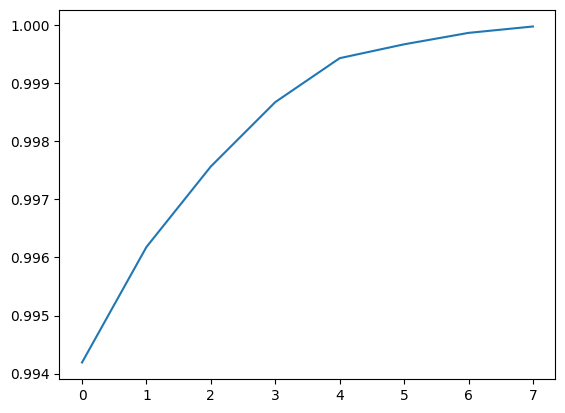

In [ ]:
evr = []
for i in range(2,10):

    svd = TruncatedSVD(n_components=i, random_state=42)
    X_reduced = svd.fit_transform(X)
    print(svd.ex)
    evr.append(svd.explained_variance_ratio_.sum())
    
plt.plot(evr)
plt.show()

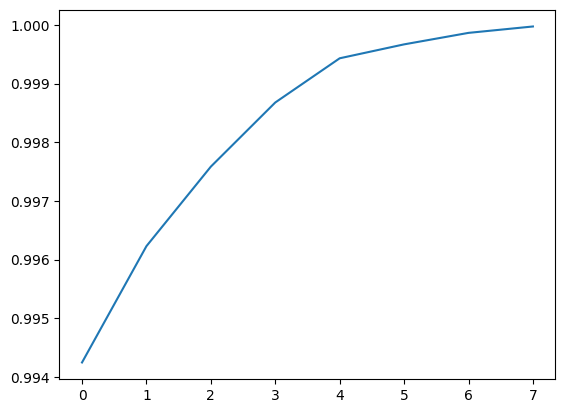

In [135]:
evr = []
for i in range(2,10):

    pca = PCA(n_components=i, random_state=42)
    X_reduced = pca.fit_transform(X)
    evr.append(pca.explained_variance_ratio_.sum())

plt.plot(evr)
plt.show()

clusters
0    3099
1    1059
3      22
2       9
4       1
Name: count, dtype: int64


C:\Users\klein\AppData\Local\Temp\ipykernel_62508\2183061125.py:21: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(df, x=0, y=1, hue="clusters", palette=sns.color_palette())


Text(0, 0.5, 'Feature 2')

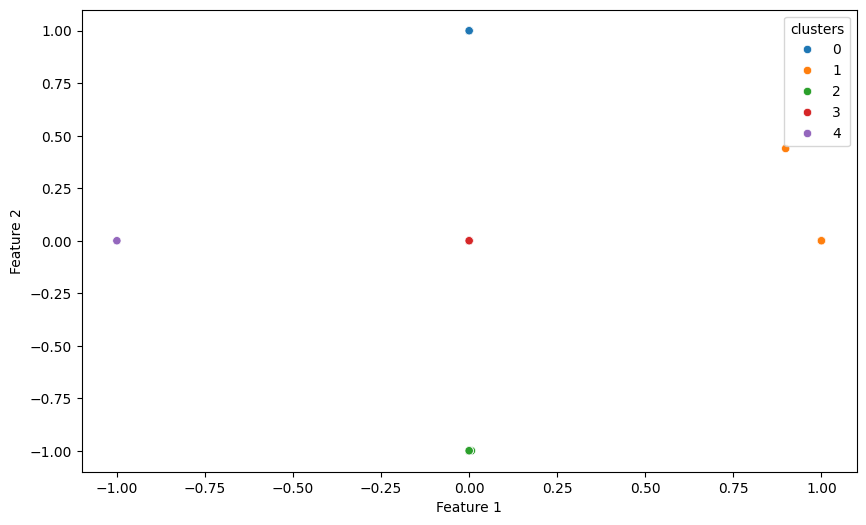

In [157]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(X)

normalizer = Normalizer()
# normalizer = MaxAbsScaler()
# normalizer = MinMaxScaler()
# normalizer = StandardScaler()
# normalizer = RobustScaler()
X_normalized = normalizer.fit_transform(X_reduced)

# Step 4: KMeans clustering (approximate cosine similarity via L2-normalized vectors)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_normalized)
data_piv["cluster"] = labels
df = pd.DataFrame(X_normalized)
df["clusters"] = labels
print(df["clusters"].value_counts())
# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x=0, y=1, hue="clusters", palette=sns.color_palette())
# plt.scatter(X[:, 0], X[:, 1], c=db_clusters, cmap='viridis', s=50)
# plt.legend(hand)
# plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

In [163]:
data_piv.loc[data_piv["cluster"]==2]

Item Faturamento BW,Empresa,Nº instalação,Classe de cálculo,SubGrupo de Tensão,Município,Meses,ConsPontaBandVerde-TE,ConsumoFPontaBandVerde-TE,ConsumoReativoExcForaPonta,ConsumoReativoExcPonta,...,EnergiaAtvInjetadaPontaTE,TusdEncConsFPonta[kWh],TusdEncConsPonta[kWh],USDConsumoReativoForaPonta,USDConsumoReativoPonta,UsoSist.Distr.,UsoSistDistrFPonta,UsoSistDistrGeração[kW],UsoSistDistrPonta,cluster
8,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,9,-163.686,-2393.232,38.893,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
56,Grupo RGE,Cliente 102,Industrial,A4,VILA FLORES,9,-26.732,-97.933,800.137,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
332,Grupo RGE,Cliente 123,Industrial,A4,TAQUARA,10,-1309.796,-22923.465,-14.653,NaN,...,NaN,148.0,9.0,NaN,NaN,120.0,NaN,NaN,NaN,2
1910,Grupo RGE,Cliente 242,Industrial,A4,BENTO GONCALVES,9,7.680,-3724.128,381.733,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1946,Grupo RGE,Cliente 245,Industrial,A4,SAO MARCOS,9,-11.270,-3707.302,48.538,0.083,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2494,Grupo RGE,Cliente 287,Industrial,A4,NOVO HAMBURGO,7,-753.155,-20134.987,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3116,Grupo RGE,Cliente 333,Industrial,A4,CAMPO BOM,7,-648.461,-11121.375,-2780.904,-277.496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3670,Grupo RGE,Cliente 6,Industrial,A4,GRAVATAI,9,90.868,-2346.279,-72.121,1.634,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3884,Grupo RGE,Cliente 76,Industrial,A4,VALE REAL,7,-71.689,-6157.937,151.085,2.423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


Text(0.5, 1.0, 'Elbow Method for Optimal k')

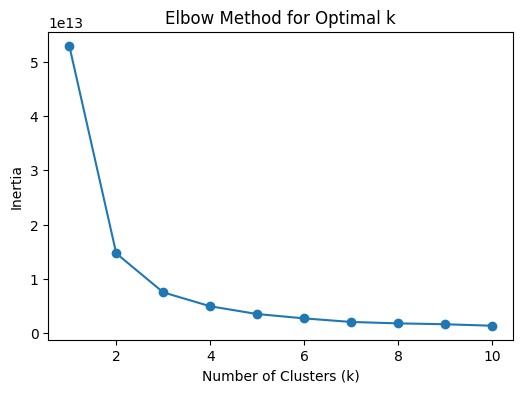

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Finding optimal number of clusters using the Elbow Method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), inertias, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_scaled = scaler.fit_transform(X)

# # Initialize and fit K-means
# kmeans = KMeans(n_clusters=3, random_state=0)
# clusters = kmeans.fit_predict(X)

# Fit Agglomerative Clustering
# agg_clustering = AgglomerativeClustering(n_clusters=2)
# agg_clusters = agg_clustering.fit_predict(X)

dbscan = DBSCAN(eps=2, min_samples=5)
db_clusters = dbscan.fit_predict(X_scaled)

x_cluster = X.copy()
x_cluster["cluster"] = db_clusters
var_list = X.columns


In [95]:
x_cluster["cluster"].value_counts()

cluster
-1     2143
 2     1930
 1       28
 0       13
 4       12
 12      11
 8       10
 7        9
 5        7
 3        7
 6        5
 11       5
 10       5
 9        5
Name: count, dtype: int64

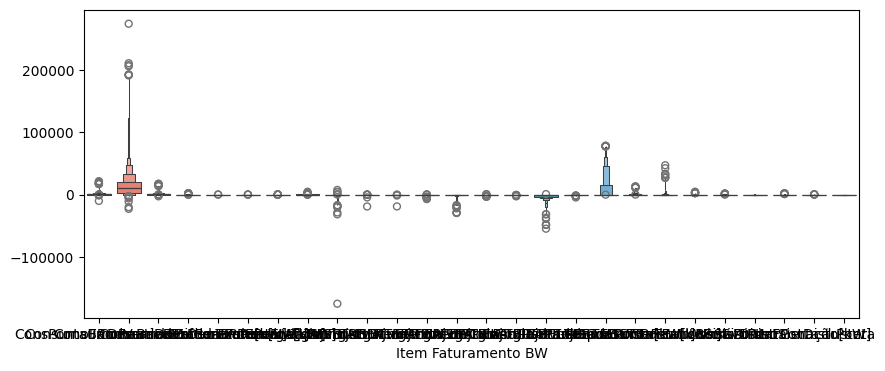

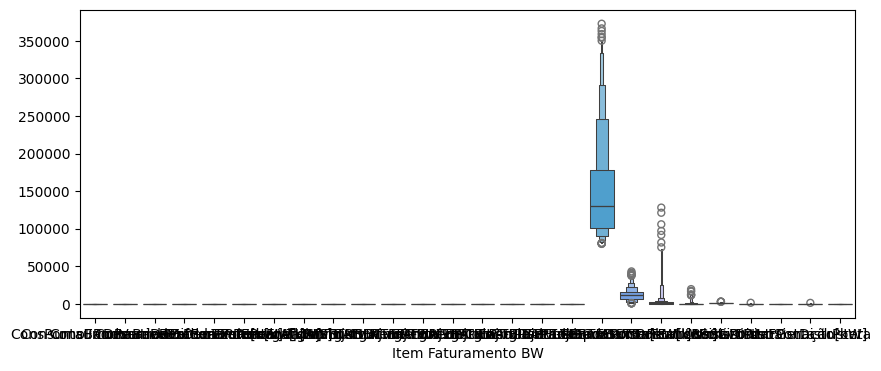

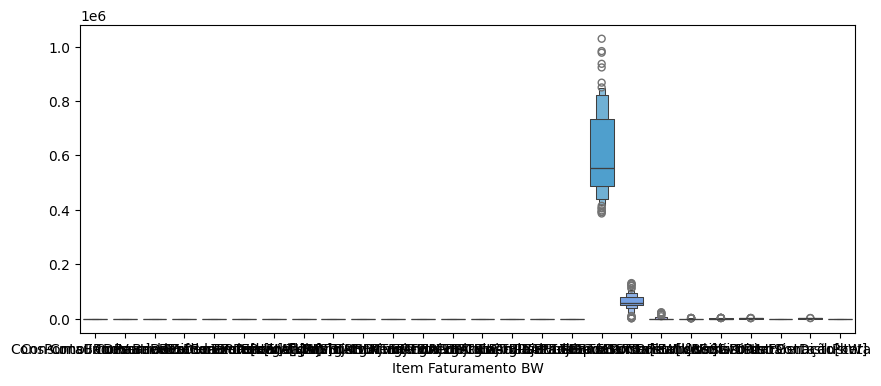

In [64]:

for cltr in x_cluster["cluster"].unique():
    df_temp = x_cluster.loc[x_cluster["cluster"]==cltr]
    plt.figure(figsize=(10,4))
    sns.boxenplot(df_temp)
    plt.show()


In [ ]:

for clusters in clusters
sns.boxplot


In [6]:
fig = px.histogram(data, x="Valores", color="Item Faturamento BW")
fig.show()

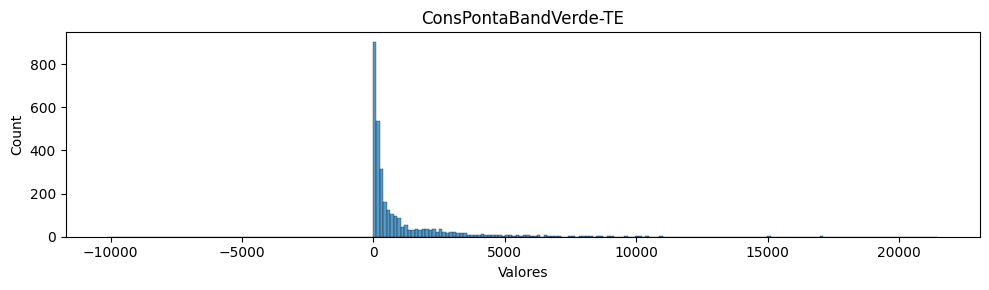

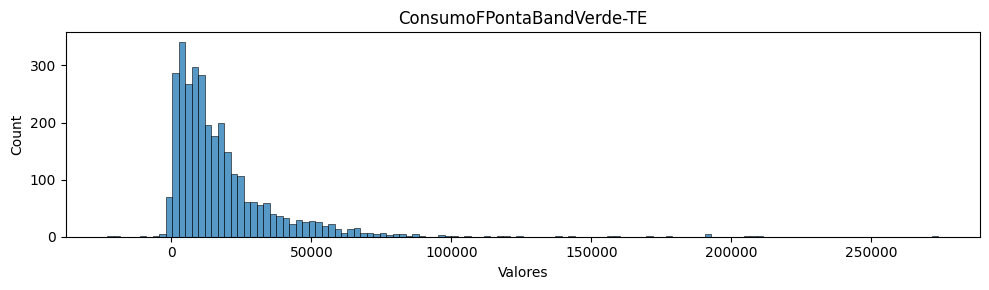

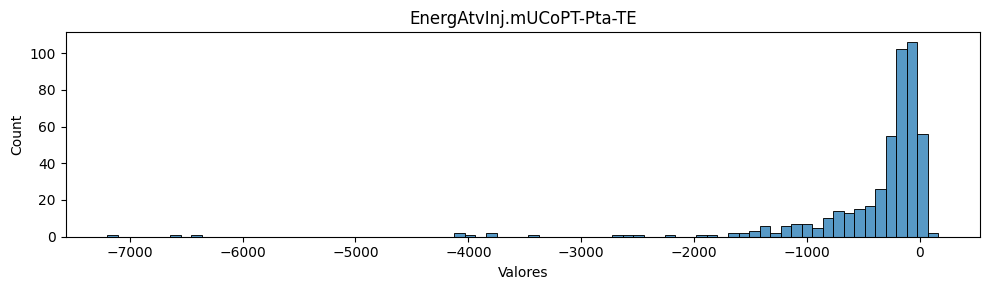

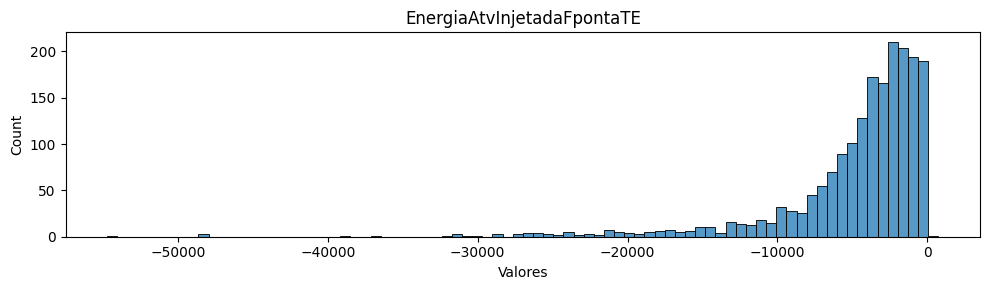

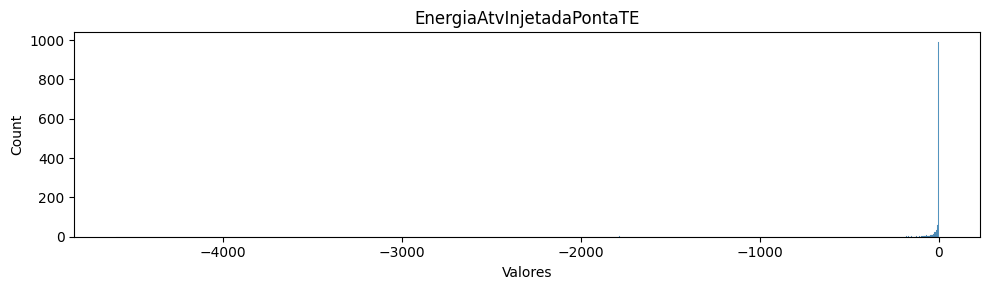

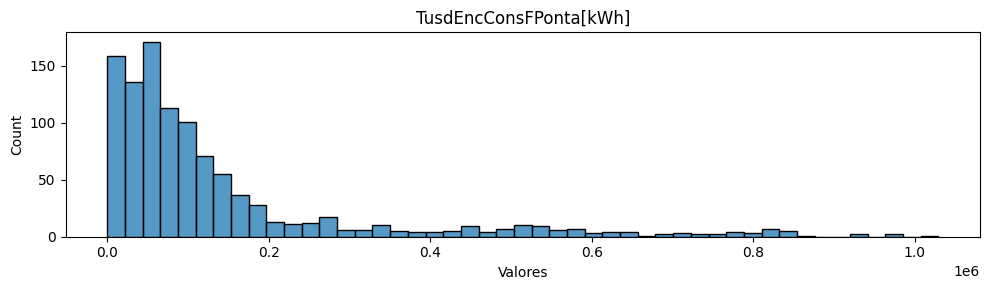

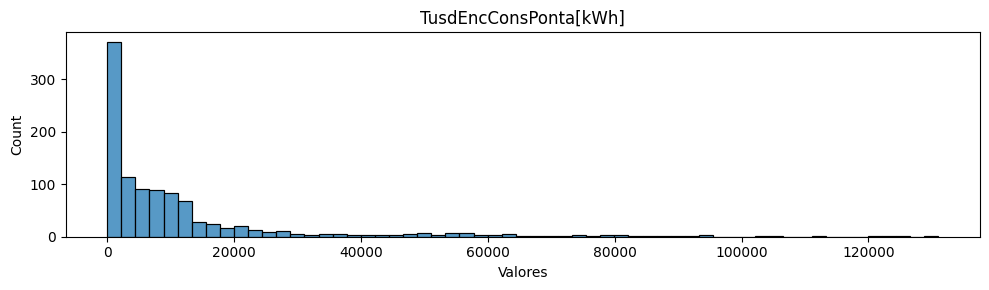

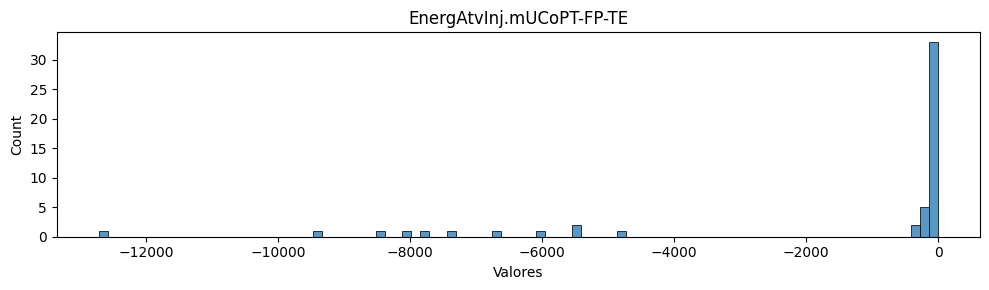

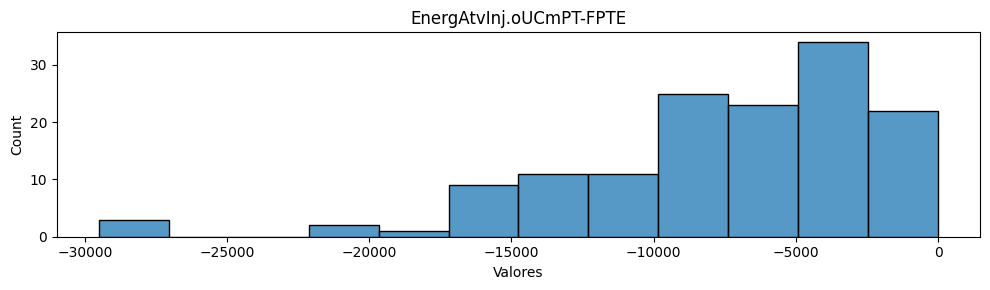

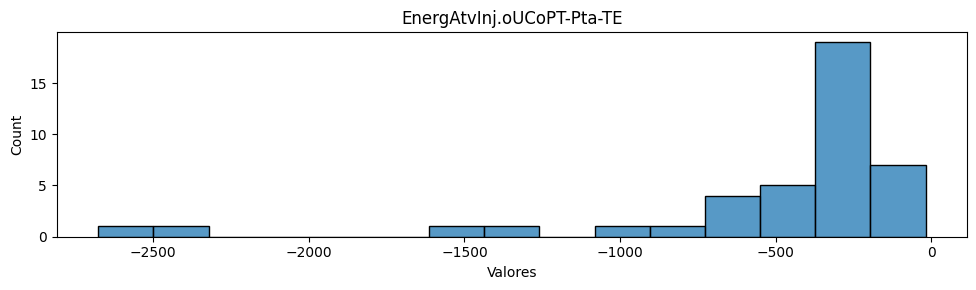

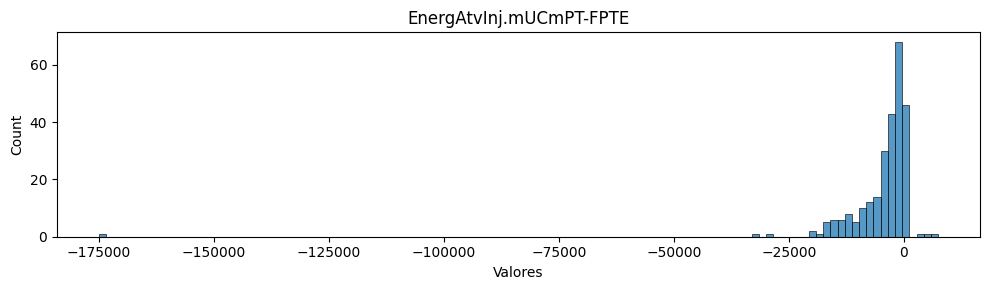

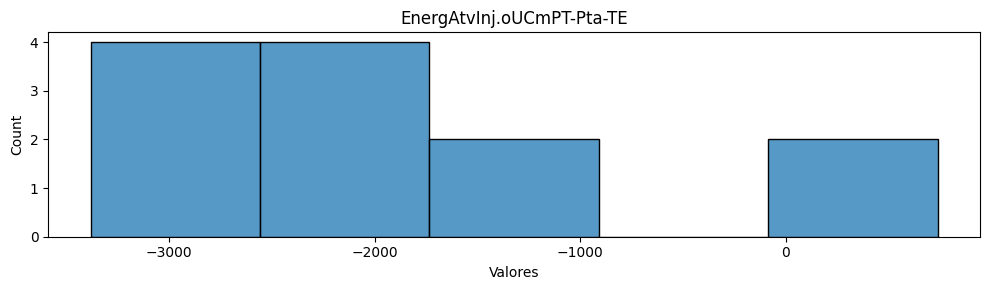

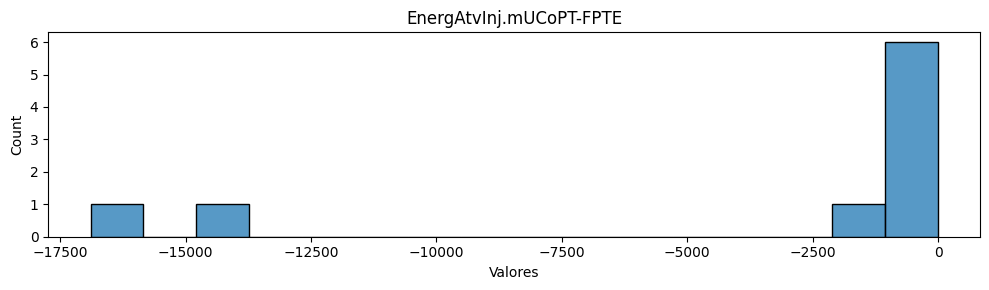

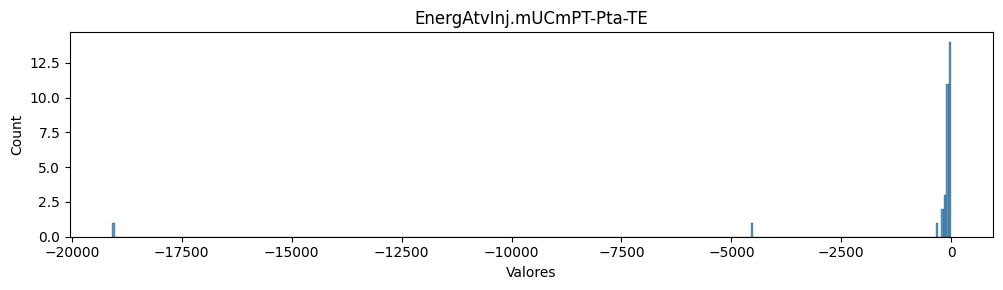

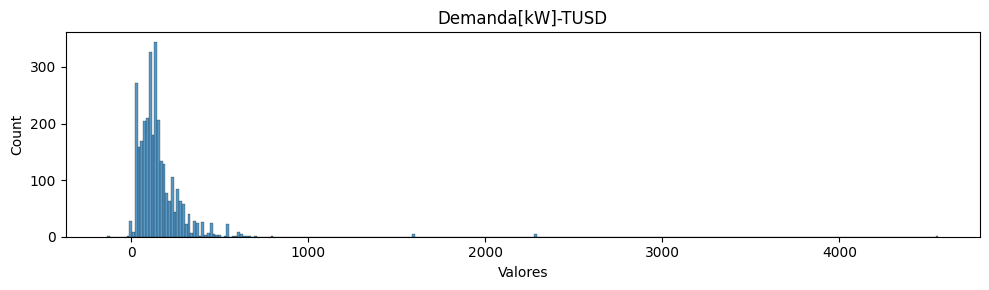

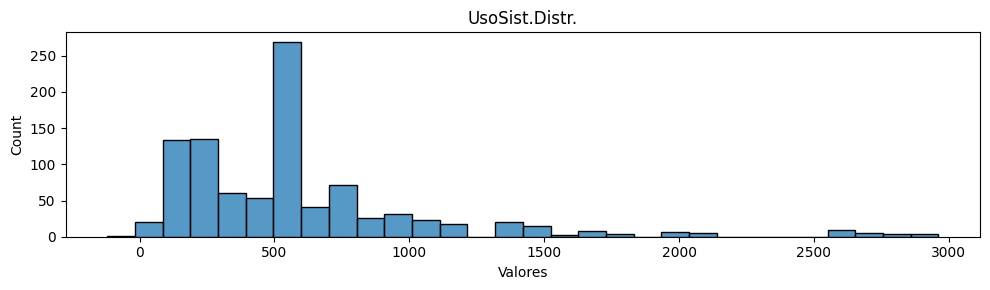

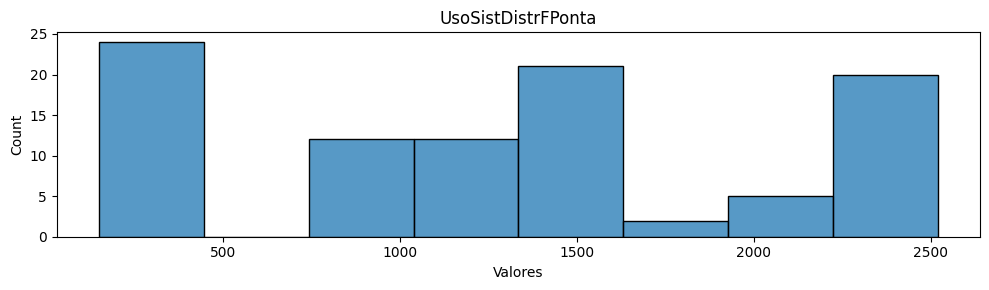

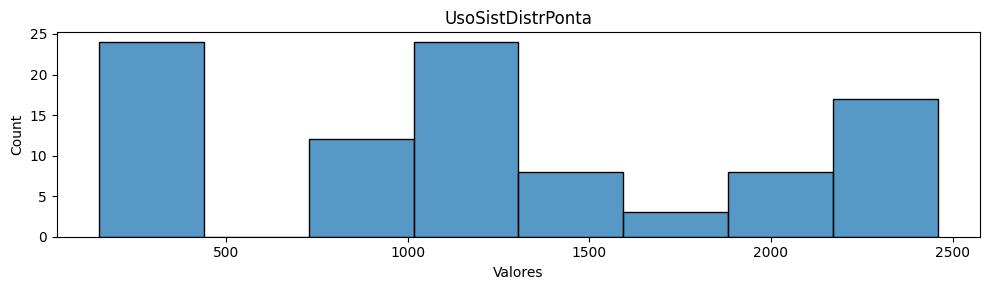

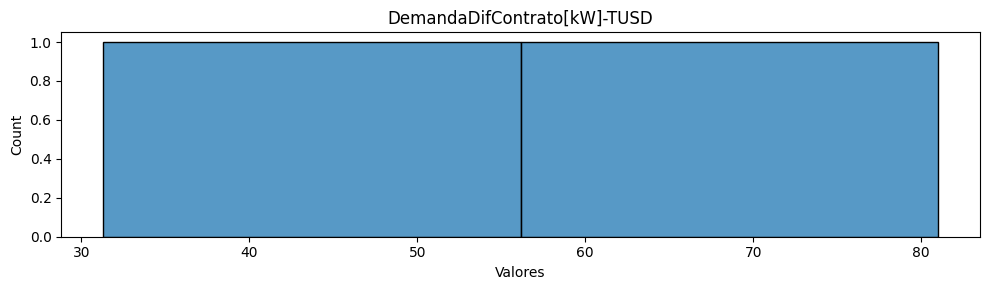

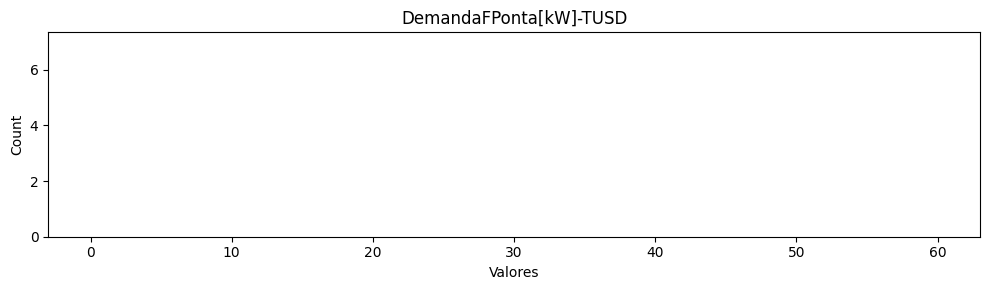

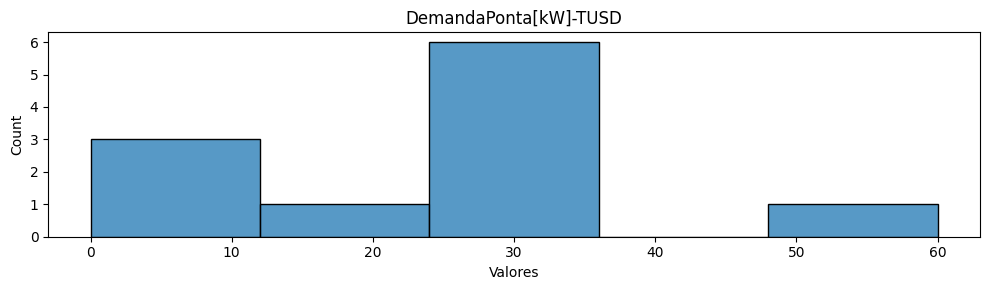

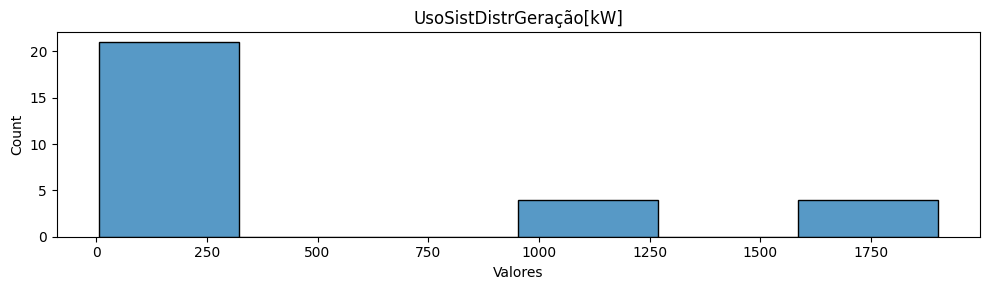

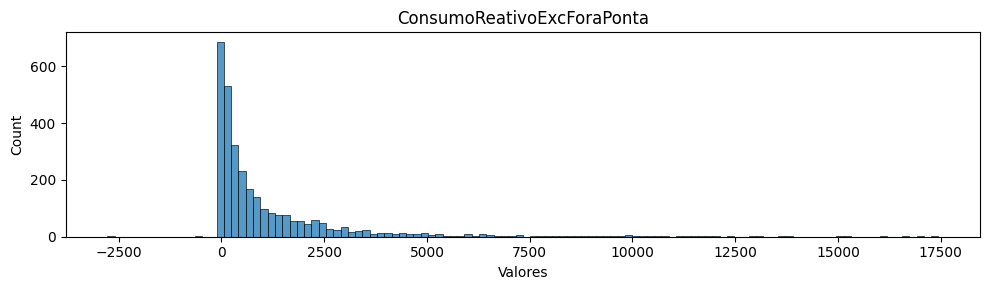

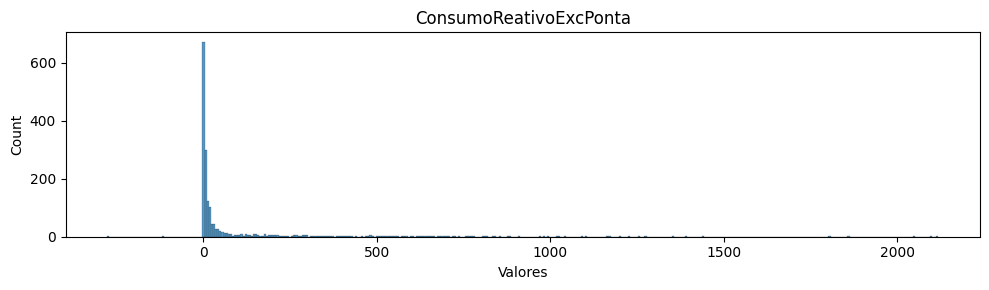

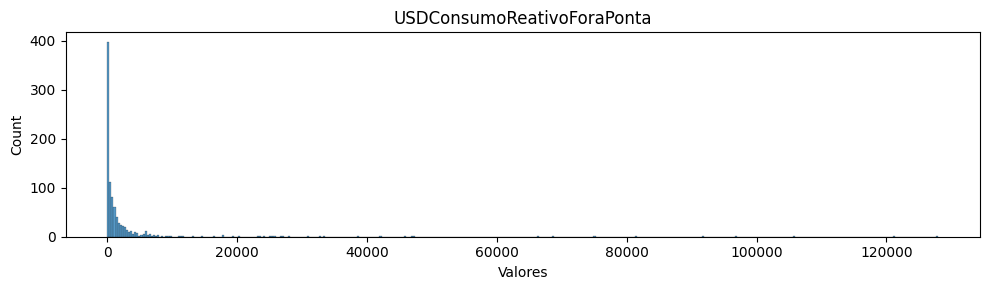

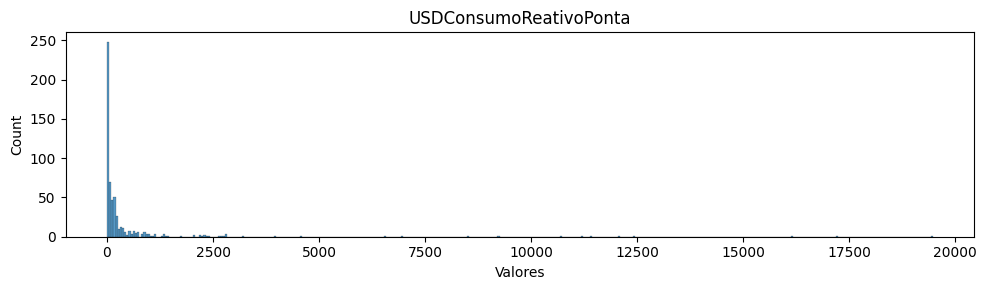

In [10]:
for item in data["Item Faturamento BW"].unique():
    data_filtered = data.loc[data["Item Faturamento BW"] == item]
    plt.figure(figsize=(10,3))
    ax = sns.histplot(data_filtered, x="Valores")
    ax.set_title(item)
    plt.tight_layout()
    plt.show()

    

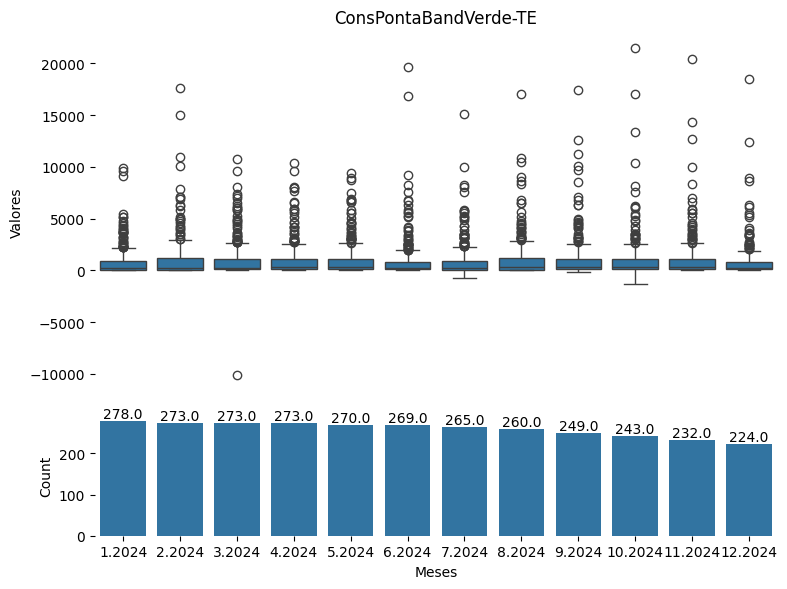

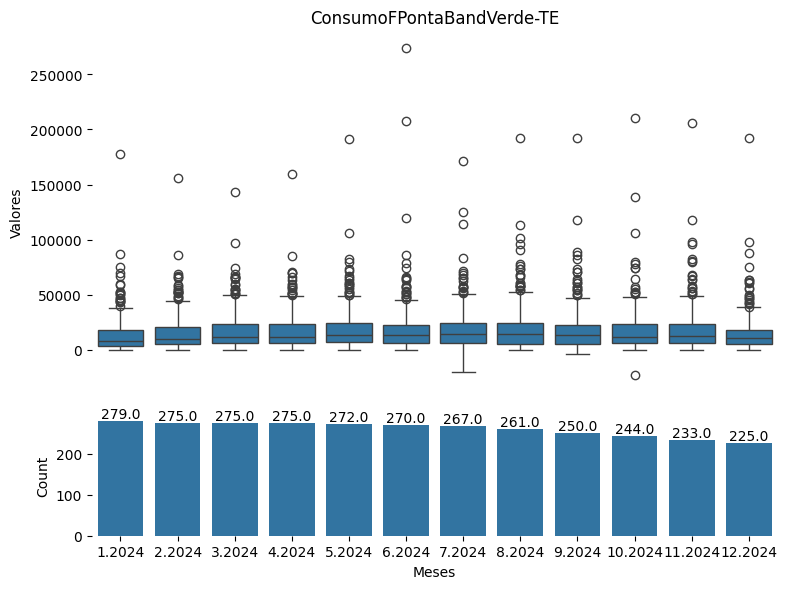

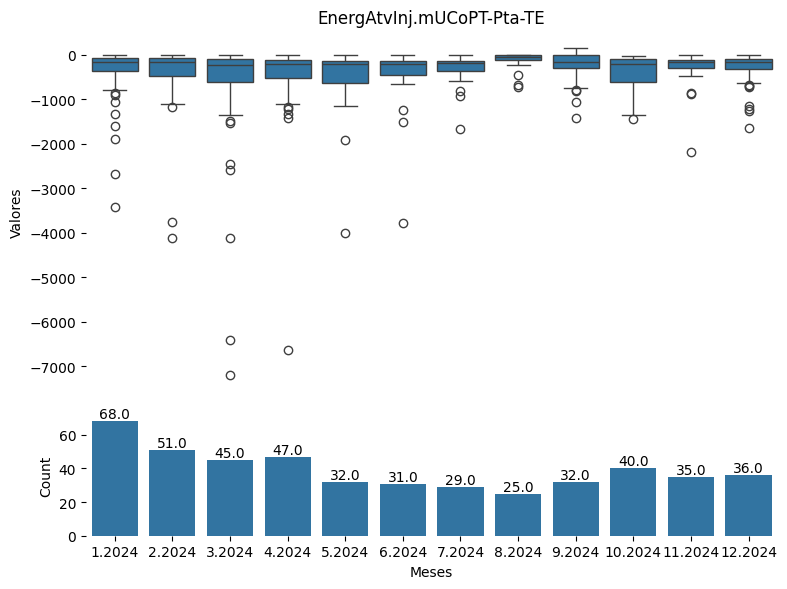

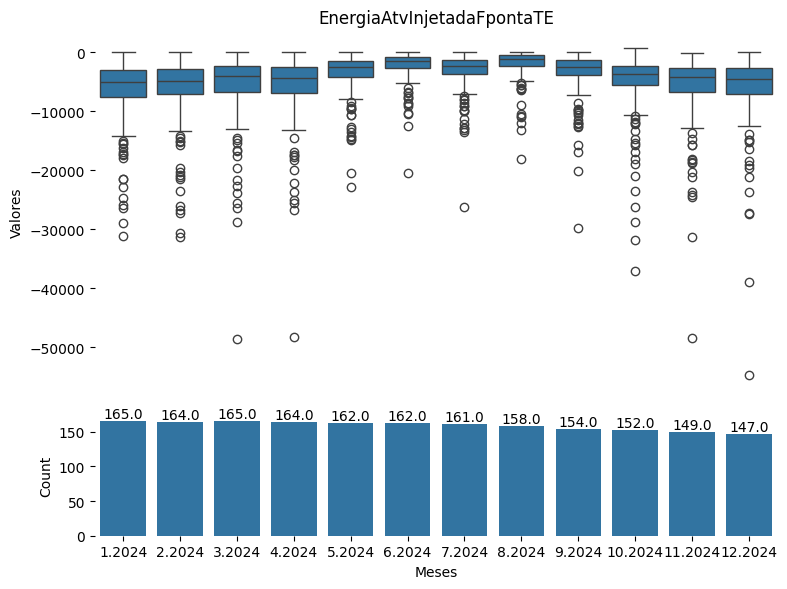

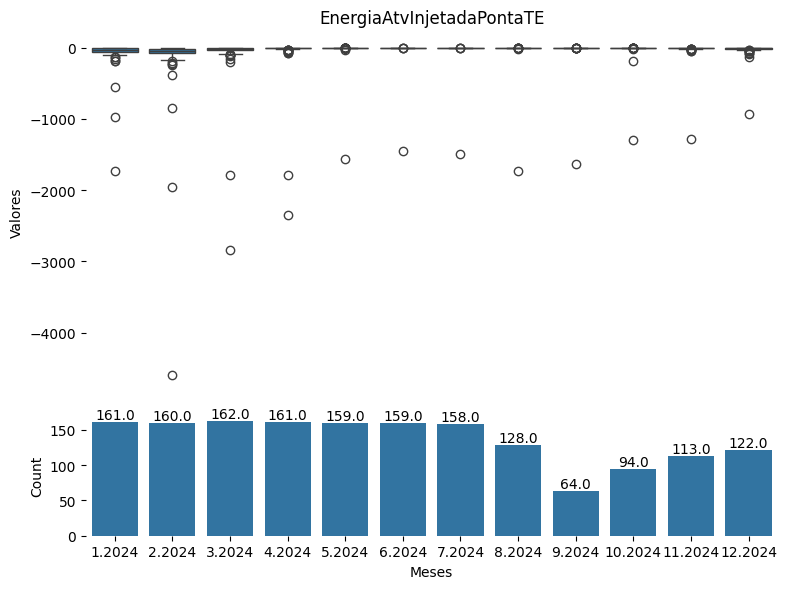

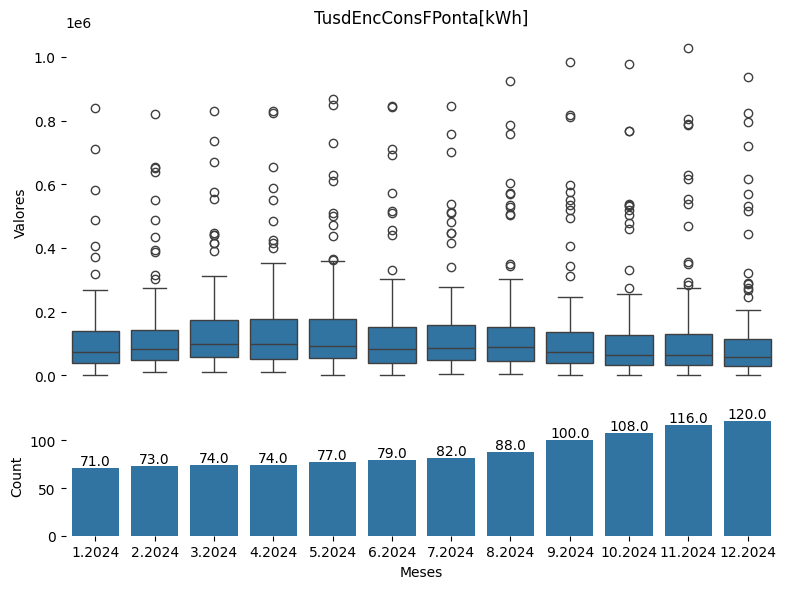

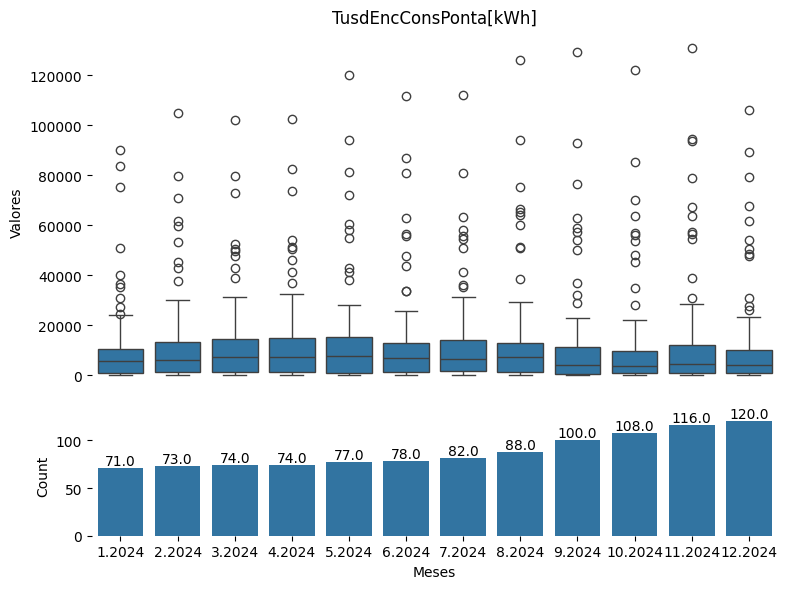

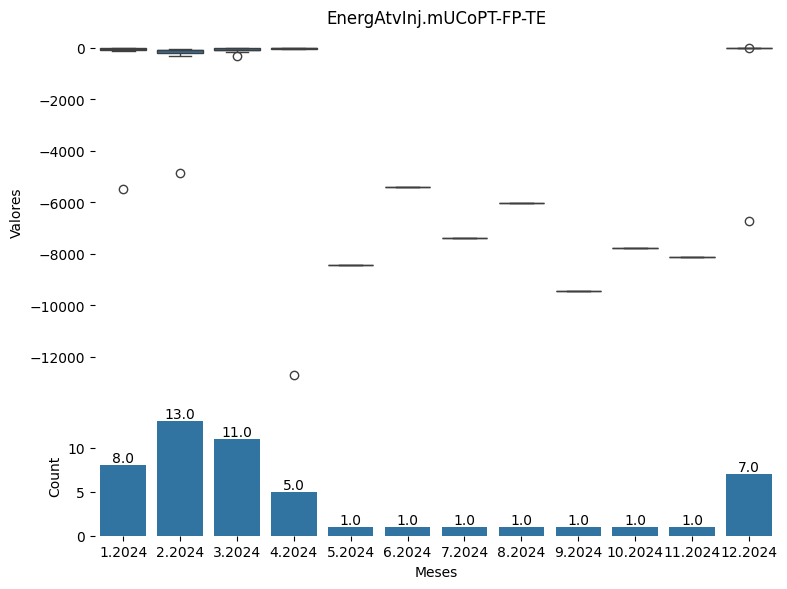

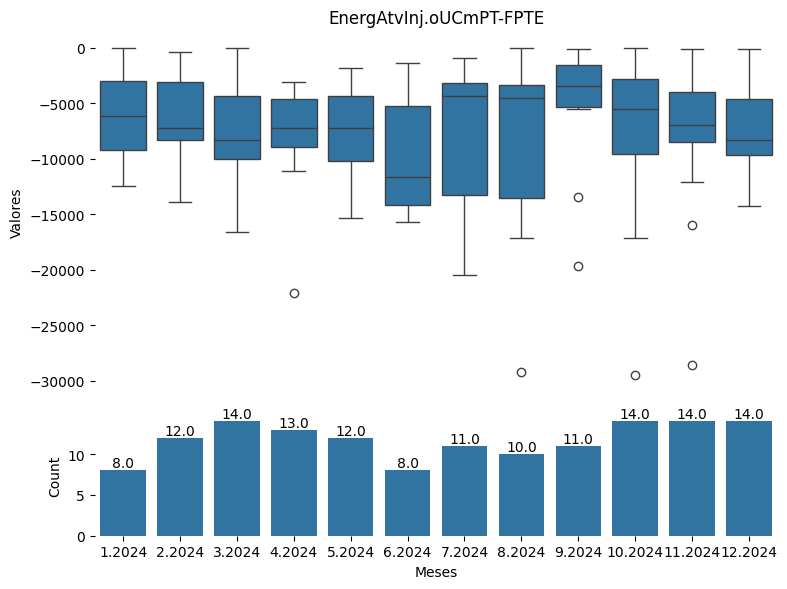

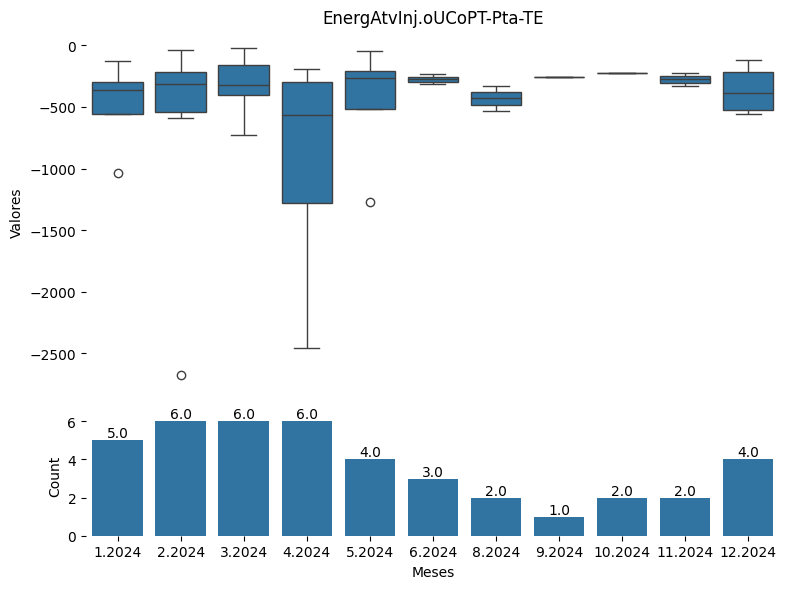

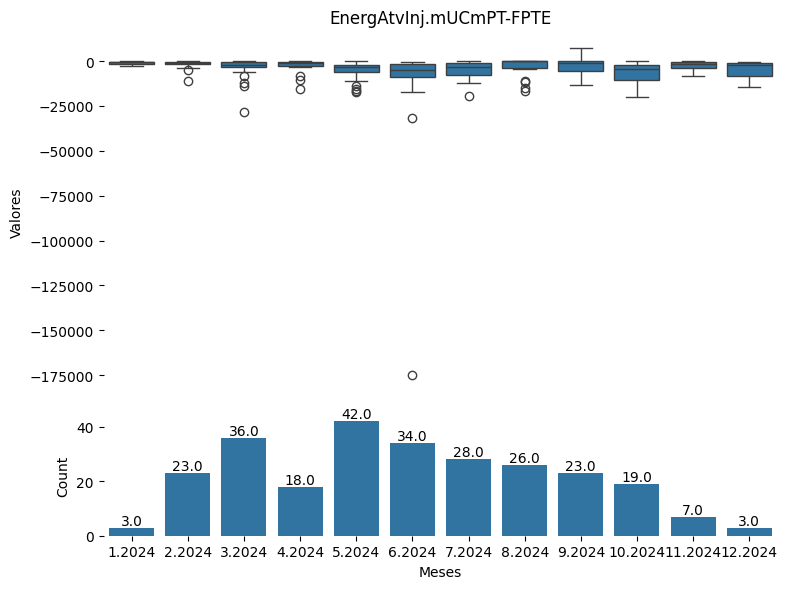

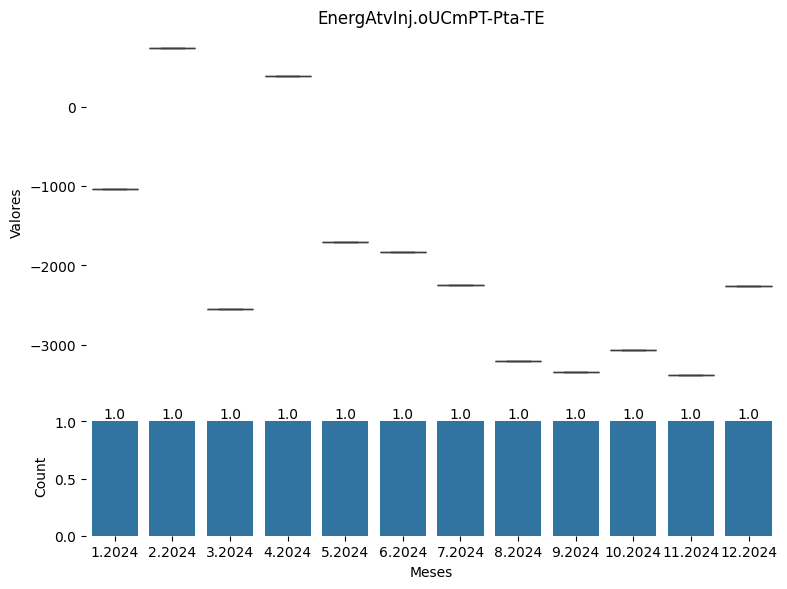

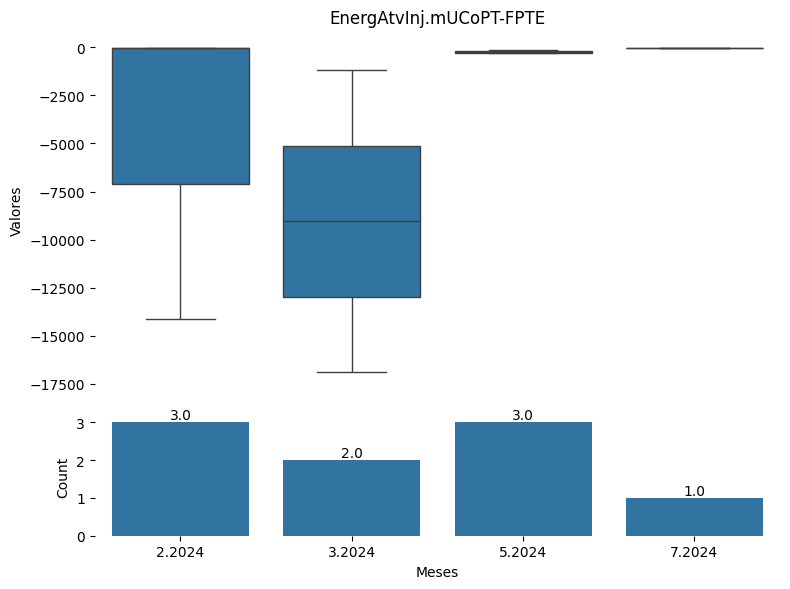

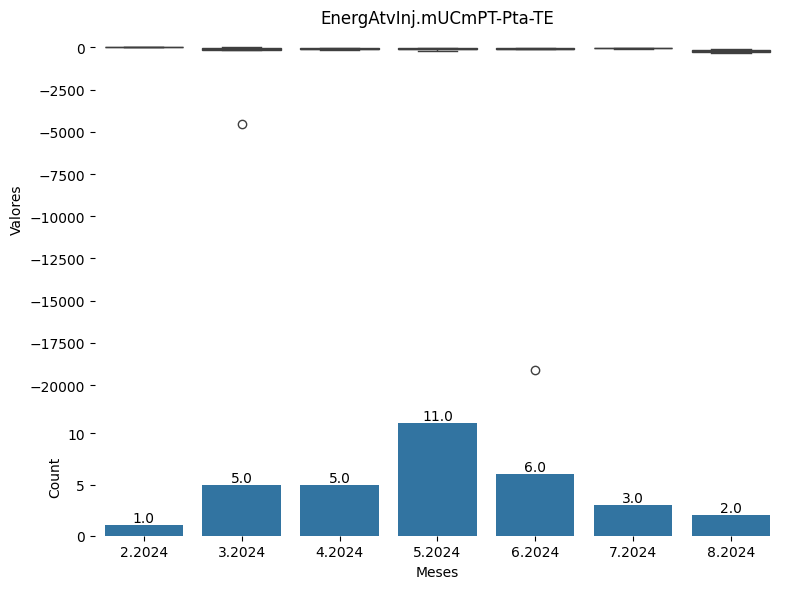

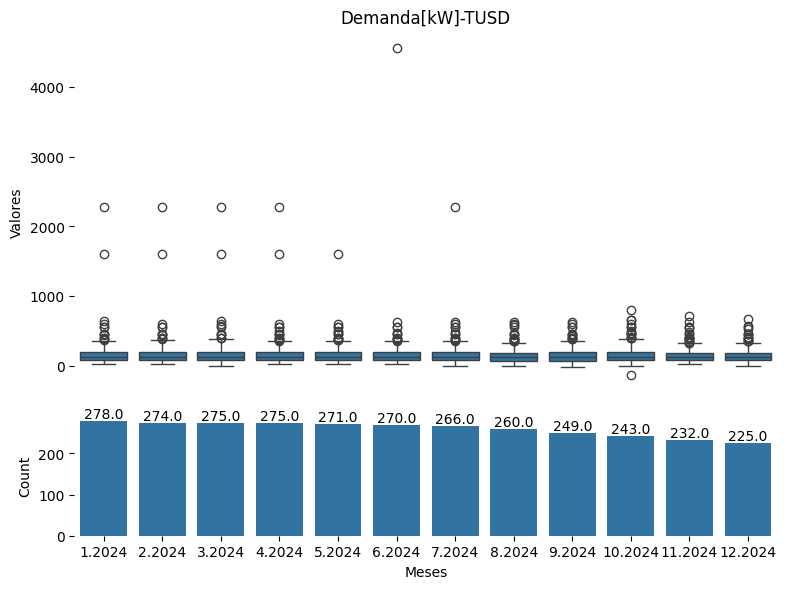

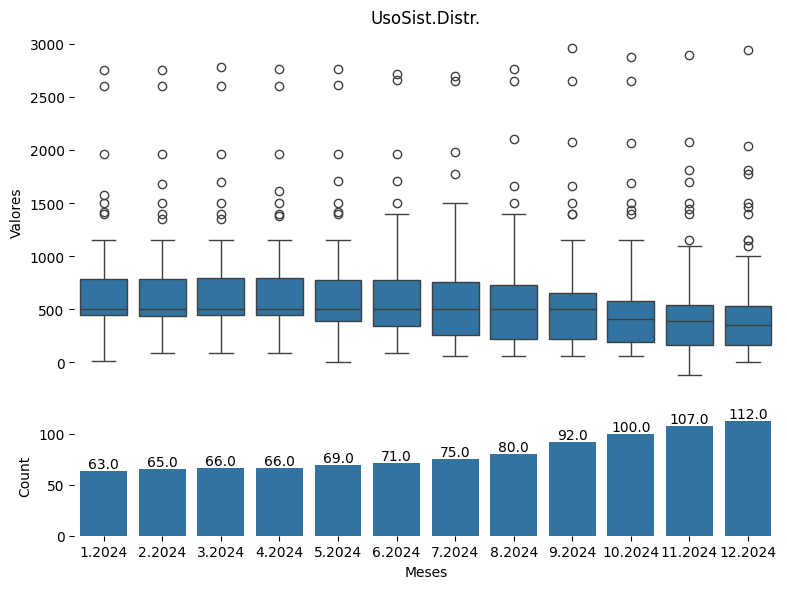

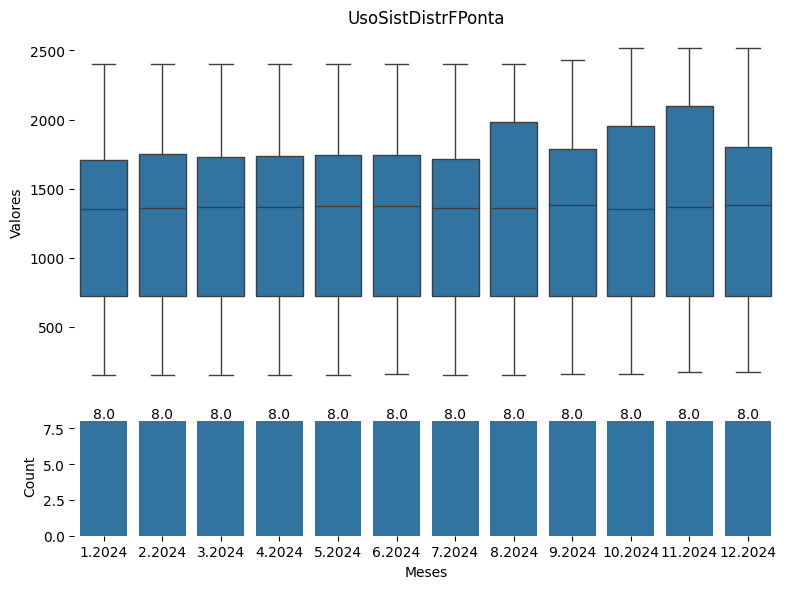

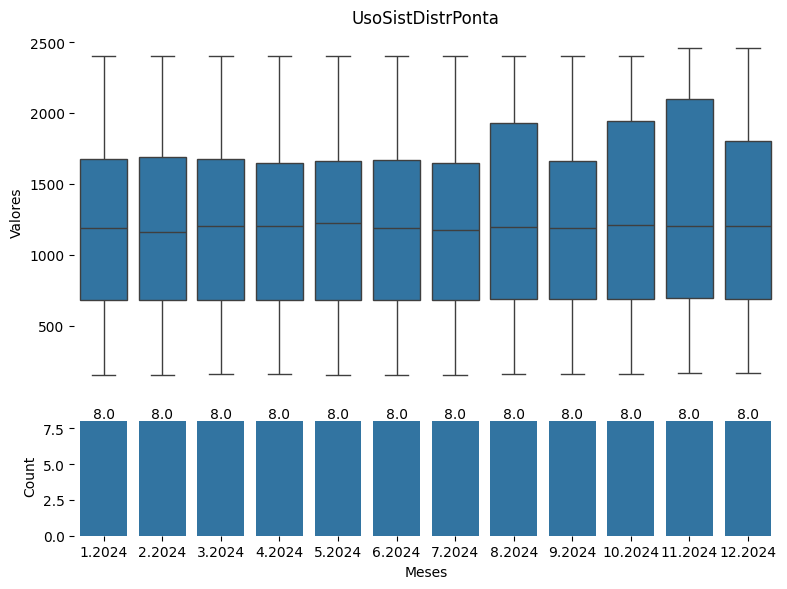

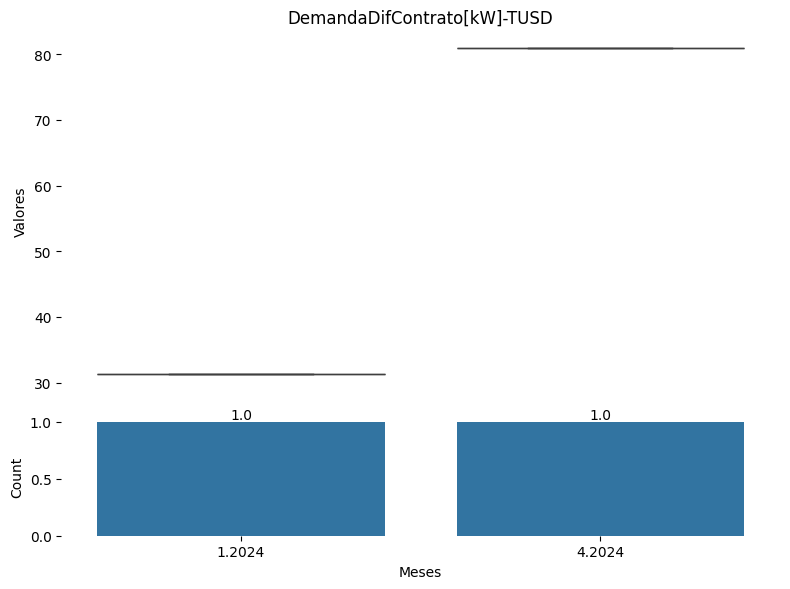

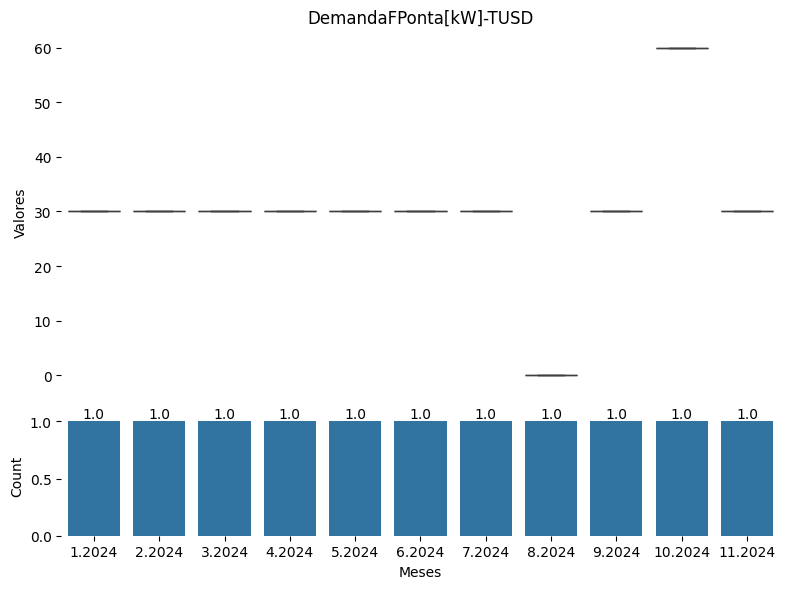

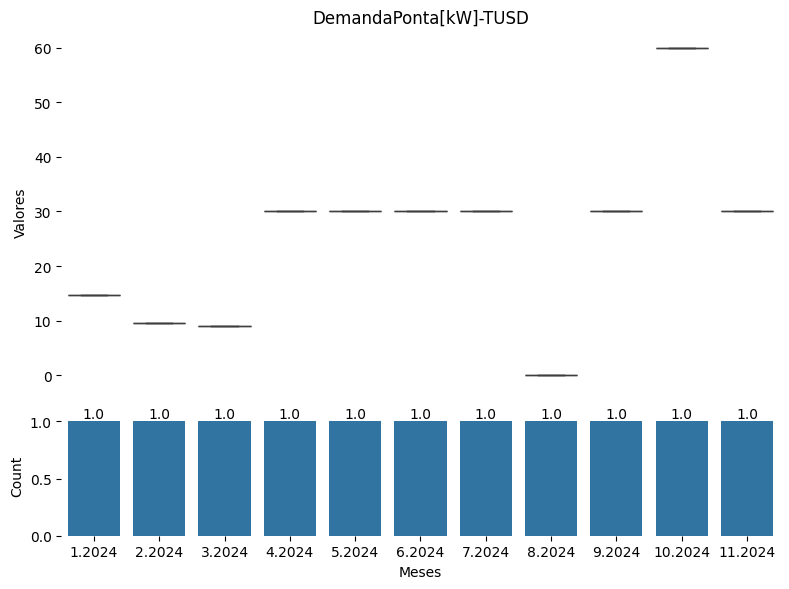

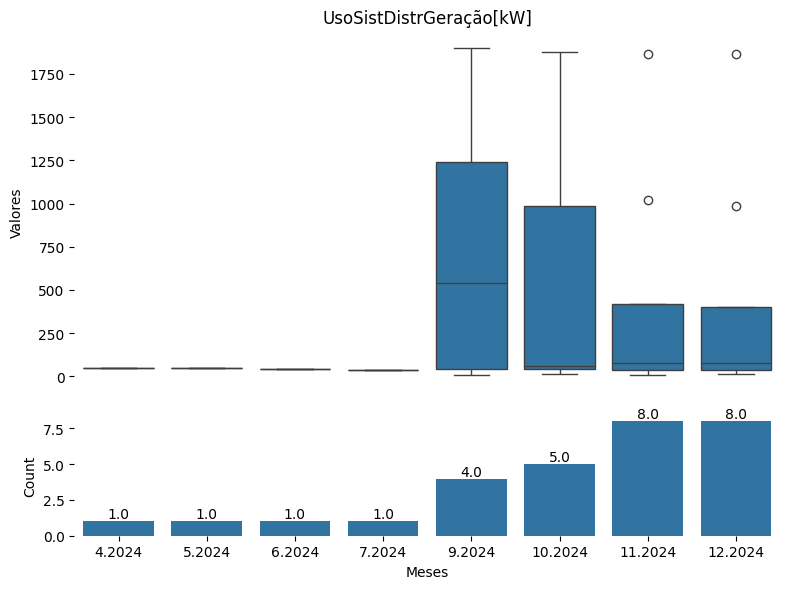

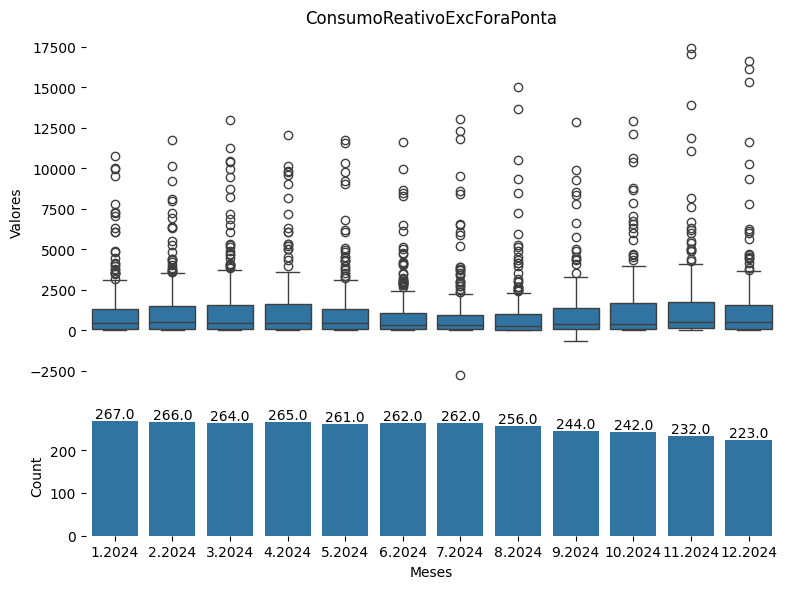

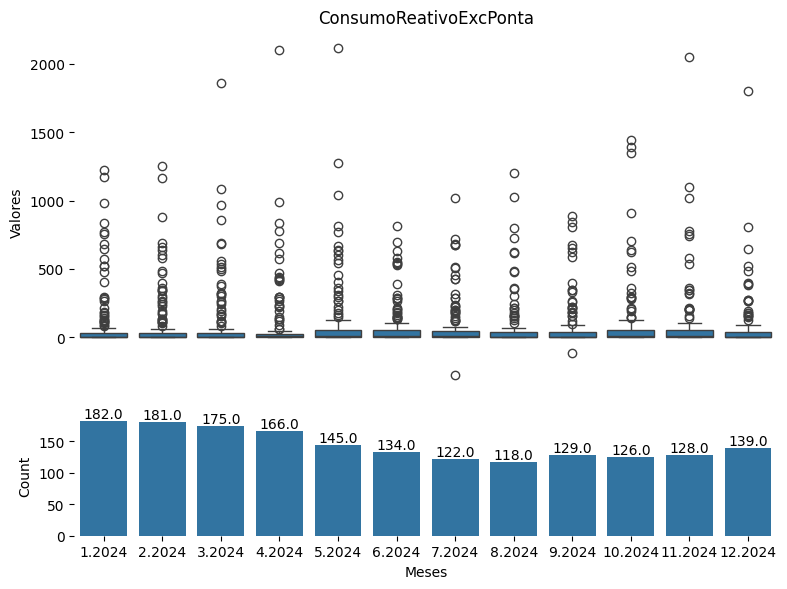

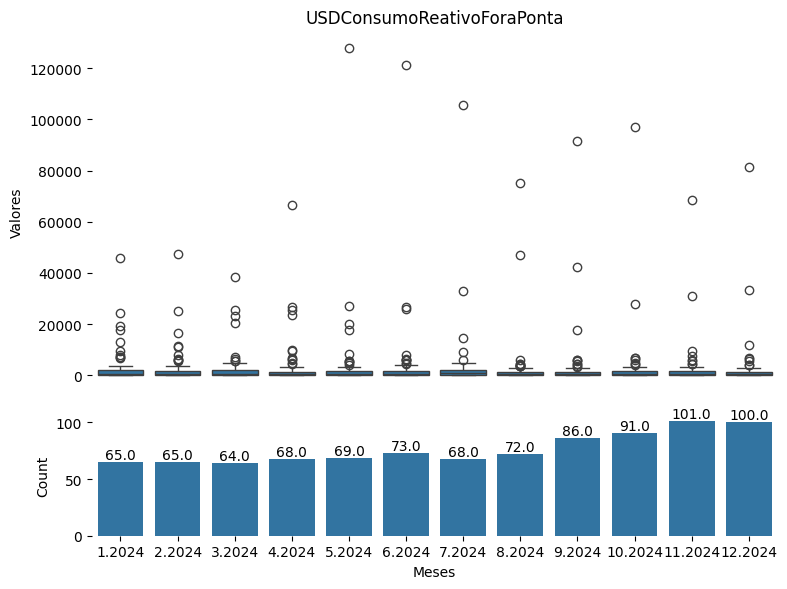

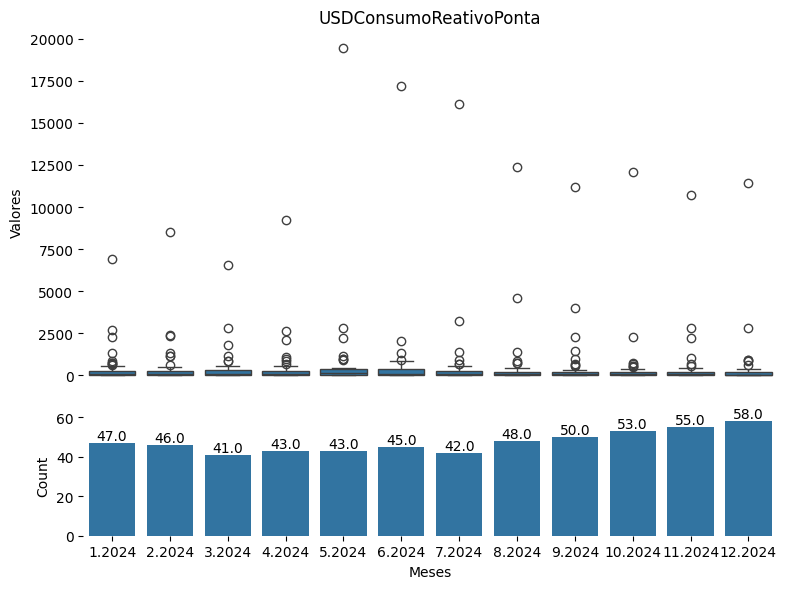

In [5]:
for item in data["Item Faturamento BW"].unique():
    data_filtered = data.loc[data["Item Faturamento BW"] == item]

    # Create subplots (2 rows, 1 column)
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Boxplot (First subplot)
    sns.boxplot(data=data_filtered, x="Meses", y="Valores", ax=axes[0])
    axes[0].set_title(f"{item}")

    # Remove X-axis markers from the boxplot
    axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Barplot (Second subplot) - Count occurrences of each month
    month_counts = data_filtered["Meses"].value_counts().reset_index()
    month_counts.columns = ["Meses", "Count"]
    barplot = sns.barplot(data=month_counts, x="Meses", y="Count", ax=axes[1])

    # Remove spines (contours)
    for spine in ["top", "right", "left", "bottom"]:
        axes[0].spines[spine].set_visible(False)
        axes[1].spines[spine].set_visible(False)

    # Add value labels to bars
    for p in barplot.patches:
        axes[1].annotate(f'{p.get_height()}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='bottom', fontsize=10,)

    # axes[1].set_title(f"Count of Occurrences for {item}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [11]:
data

,Empresa,Nº instalação,Classe de cálculo,SubGrupo de Tensão,Município,Item Faturamento BW,SubAgrupador de Fatu,Meses,Valores
0,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,ConsPontaBandVerde-TE,Consumo,1.2024,463.296
1,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,ConsumoFPontaBandVerde-TE,Consumo,1.2024,1365.264
2,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,EnergAtvInj.mUCoPT-Pta-TE,Energia Compensada,1.2024,-420.816
3,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,EnergiaAtvInjetadaFpontaTE,Energia Compensada,1.2024,-1365.264
4,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,EnergiaAtvInjetadaPontaTE,Energia Compensada,1.2024,-42.480
...,...,...,...,...,...,...,...,...,...
23528,Grupo RGE,Cliente 347,Industrial,A4,CRUZ ALTA,USDConsumoReativoPonta,FER,12.2024,11413.662
23529,Grupo RGE,Cliente 348,Industrial,A4,IPE,USDConsumoReativoForaPonta,FER,12.2024,5.771
23530,Grupo RGE,Cliente 348,Industrial,A4,IPE,USDConsumoReativoPonta,FER,12.2024,0.267
23531,Grupo RGE,Cliente 349,Industrial,A4,PORTAO,USDConsumoReativoForaPonta,FER,12.2024,77.091


In [19]:
item_occ = data[["Item Faturamento BW", "Meses", "Valores"]].groupby(["Item Faturamento BW", "Meses"]).count()
item_occ = item_occ.reset_index()
item_occ["Meses"] = item_occ["Meses"].astype(str)
item_occ


,Item Faturamento BW,Meses,Valores
0,ConsPontaBandVerde-TE,1.2024,278
1,ConsPontaBandVerde-TE,2.2024,273
2,ConsPontaBandVerde-TE,3.2024,273
3,ConsPontaBandVerde-TE,4.2024,273
4,ConsPontaBandVerde-TE,5.2024,270
...,...,...,...
277,UsoSistDistrPonta,8.2024,8
278,UsoSistDistrPonta,9.2024,8
279,UsoSistDistrPonta,10.2024,8
280,UsoSistDistrPonta,11.2024,8


In [21]:
px.line(item_occ,x="Meses", y="Valores", color="Item Faturamento BW")

In [24]:
data

,Empresa,Nº instalação,Classe de cálculo,SubGrupo de Tensão,Município,Item Faturamento BW,SubAgrupador de Fatu,Meses,Valores
0,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,ConsPontaBandVerde-TE,Consumo,1.2024,463.296
1,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,ConsumoFPontaBandVerde-TE,Consumo,1.2024,1365.264
2,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,EnergAtvInj.mUCoPT-Pta-TE,Energia Compensada,1.2024,-420.816
3,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,EnergiaAtvInjetadaFpontaTE,Energia Compensada,1.2024,-1365.264
4,Grupo RGE,Cliente 1,Industrial,A4,CAXIAS DO SUL,EnergiaAtvInjetadaPontaTE,Energia Compensada,1.2024,-42.480
...,...,...,...,...,...,...,...,...,...
23528,Grupo RGE,Cliente 347,Industrial,A4,CRUZ ALTA,USDConsumoReativoPonta,FER,12.2024,11413.662
23529,Grupo RGE,Cliente 348,Industrial,A4,IPE,USDConsumoReativoForaPonta,FER,12.2024,5.771
23530,Grupo RGE,Cliente 348,Industrial,A4,IPE,USDConsumoReativoPonta,FER,12.2024,0.267
23531,Grupo RGE,Cliente 349,Industrial,A4,PORTAO,USDConsumoReativoForaPonta,FER,12.2024,77.091
